In [1]:
%load_ext autoreload
%autoreload 2
%aimport RNN_model, RNN_apply_ind

# MSE

In [2]:
import RNN_apply_ind, os, json, argparse

folder_path = r'C:\Users\qilei.zhang\OneDrive - Frontier Airlines\Documents\Data\USconti'
seats_file_name = r'\Schedule_Monthly_Summary_Report_Conti.csv'
perf_file_name = r'\Airline_Performance_Report_Conti.csv'
apply_file_name = '\Schedule_Monthly_Summary_2023Q123.csv'
# Load parameters from the JSON file.
if not os.path.exists('parameters.json'):
    print("parameters.json does not exist, Find the file and put it in the same folder as this file")
with open('parameters.json', 'r') as f:
    args = argparse.Namespace(**json.load(f))

RNN_apply_ind.main_apply(args, folder_path, seats_file_name, perf_file_name, apply_file_name)

Using the provided arguments.
-------- Start ----------
Will use cpu as device
Missing airports database loaded.
Major hubs database loaded.
Dimension mapping loaded.
Applying data does not exist, will create it
The data is cleaned.
The geo features are assigned.
The origin, destination and airline are encoded.
The airports coordinates are calculated.
The airline features are assigned.
The pandamic features are assigned.
The competitors are calculated.
The market share is calculated.
The market size is calculated.
The test data is created.
Original data loaded.
Main scaler rebuilt.
Seat scaler rebuilt.
Apply data scaled.
Validation data scaled.
Date features created.
Validation data prepared.
Model loaded
Evaluating: batch 100 of 664
Evaluating: batch 200 of 664
Evaluating: batch 300 of 664
Evaluating: batch 400 of 664
Evaluating: batch 500 of 664
Evaluating: batch 600 of 664
           MAE          RMSE       MAPE  std       <1%       <5%      <10%  \
0  4260.858398   6365.730957  28.

# GLS

Using the provided arguments.
-------- Start ----------
Will use cpu as device
Missing airports database loaded.
Major hubs database loaded.
Dimension mapping loaded.
Applying data exists, will load it
Original data loaded.
Main scaler rebuilt.
Seat scaler rebuilt.
Apply data scaled.
Validation data scaled.
Date features created.
Validation data prepared.
Model loaded
Evaluating: batch 100 of 664
Evaluating: batch 200 of 664
Evaluating: batch 300 of 664
Evaluating: batch 400 of 664
Evaluating: batch 500 of 664
Evaluating: batch 600 of 664
           MAE          RMSE       MAPE          std       <1%       <5%  \
0  4912.316406   8314.106445  24.011293  3117.188965  0.042701  0.212349   
1  6034.407715  10276.609375  20.837500  4859.849121  0.045009  0.209463   
2  7159.291992  11731.722656  20.426729  5568.463867  0.035776  0.173687   
3  7998.903809  13206.706055  24.077120  6003.868652  0.030198  0.160415   

       <10%      <20%  
0  0.425466  0.718215  
1  0.396615  0.675515  
2 

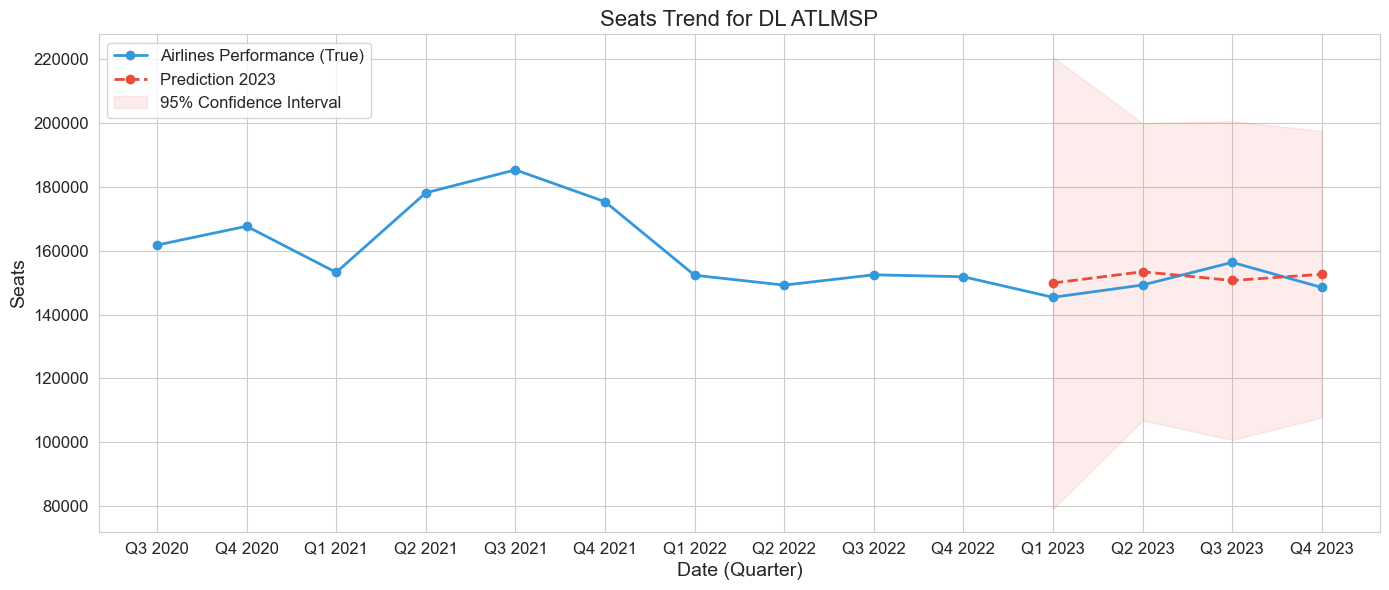

Route Not Existed for F9 NYCSFO...


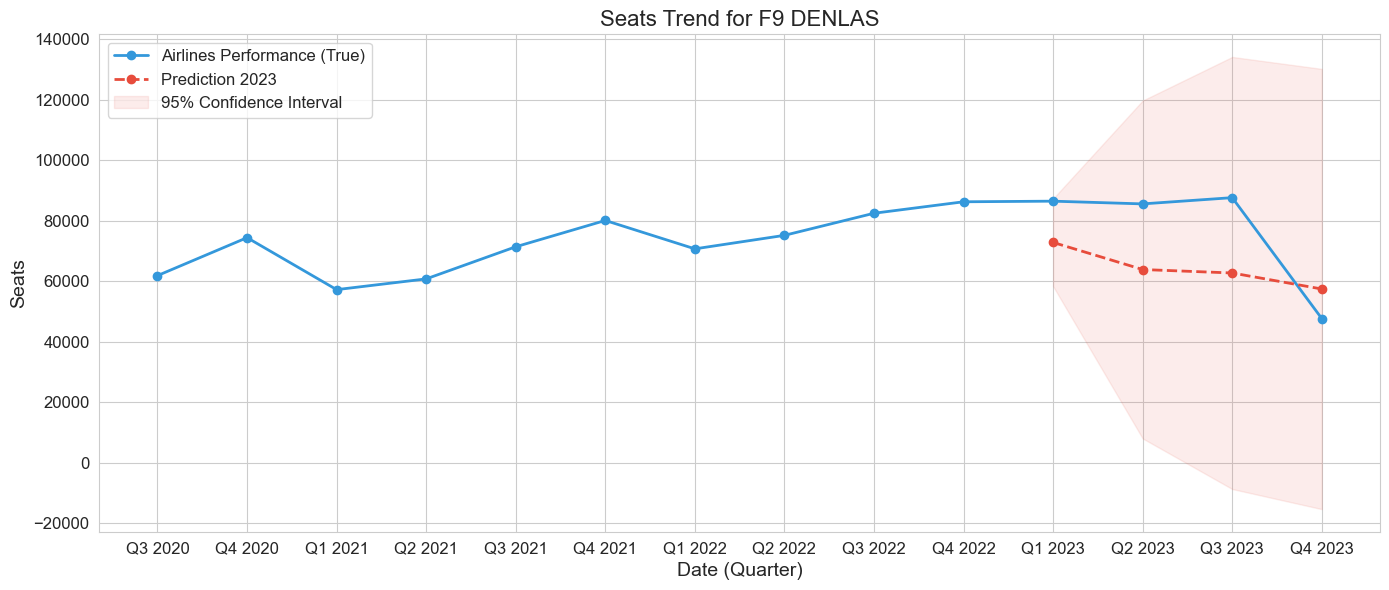

Time used: 14.221918058395385 minutes
-------- End ----------


In [4]:
import RNN_apply_ind, os, json, argparse

folder_path = r'C:\Users\qilei.zhang\OneDrive - Frontier Airlines\Documents\Data\USconti'
seats_file_name = r'\Schedule_Monthly_Summary_Report_Conti.csv'
perf_file_name = r'\Airline_Performance_Report_Conti.csv'
apply_file_name = '\Schedule_Monthly_Summary_2023Q1234.csv'
# Load parameters from the JSON file.
if not os.path.exists('parameters.json'):
    print("parameters.json does not exist, Find the file and put it in the same folder as this file")
with open('parameters.json', 'r') as f:
    args = argparse.Namespace(**json.load(f))

RNN_apply_ind.main_apply(args, folder_path, seats_file_name, perf_file_name, apply_file_name)